In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import galsim
import galflow as gf

Populating the interactive namespace from numpy and matplotlib


## Generate a Galsim example

2.4891686


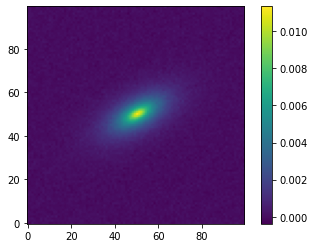

In [2]:
gal_flux = 2.5    # counts
gal_r0 = 1.1    # arcsec
pixel_scale = 0.2  # arcsec / pixel
N = 100            # image width/height

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=N,ny=N, scale=pixel_scale),
                               x_interpolant='linear')

imgal = gal.drawImage(nx=N, ny=N, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)

imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

g1 = 0.2
g2 = 0.3
g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])

imgal = gf.shear(imgal, g1, g2)

im = imgal[0,...,0] + 0.0001*tf.random.normal([N,N])
print(sum(im))
#im = im/sum(im) * 2.
imshow(im, origin='lower')
colorbar()

## Model Fitting with autometacal

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
[e1, e2] [0.1991073 0.2982811] / [0.2, 0.3]
flux 2.4891686 / 2.5
radius 1.0171679 / 1.1


Text(0.5, 1.0, 'gradient of e2 w.r.t. input')

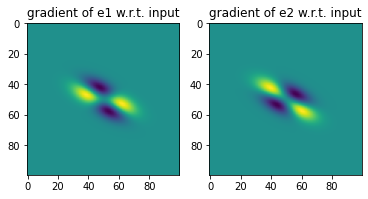

In [3]:
from autometacal import fitting

with tf.GradientTape() as g:
  g.watch(im)
  params, e, flux, radius = fitting.fit_multivariate_gaussian(im, pixel_scale, update_params={'lr':30.})

grad = g.jacobian(e, im)

print('[e1, e2]', e.numpy(), '/', [g1.numpy()[0], g2.numpy()[0]])
print('flux', flux.numpy(), '/', gal_flux)
print('radius', radius.numpy(), '/', gal_r0)

# gradients
subplot(121)
imshow(grad[0,...])
title('gradient of e1 w.r.t. input')

subplot(122)
imshow(grad[1,...])
title('gradient of e2 w.r.t. input')

In [4]:
coords = tf.stack(tf.meshgrid(tf.range(-N/2,N/2), tf.range(-N/2,N/2)), axis=-1).numpy()

In [5]:
def model(z):
  A = z[0]
  tril_params = z[1:]
  b = tfb.FillScaleTriL(
     diag_bijector=tfb.Softplus(),
     diag_shift=None)
  dist = tfd.MultivariateNormalTriL(loc=[0.,0.], 
                                    scale_tril=b.forward(x=tril_params))
  return A * dist.prob(coords)

In [6]:
# Let's test it out
A = sum(im)
A = tf.reshape(tf.convert_to_tensor(A, dtype=tf.float32), [-1])
params = tf.ones(3)*5
z = tf.concat([A, params], axis=0)

x = model(z)

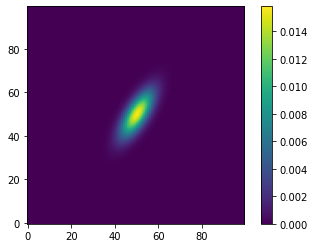

In [7]:
imshow(x, origin='lower')
colorbar()

In [8]:
loss = lambda x, p: tf.reduce_sum((x - model(p))**2)

In [9]:
def f(x, z):
  with tf.GradientTape() as g:
    g.watch(z)
    l = loss(x, z)
  
  grad = g.gradient(l, z)
  #print(grad)
  return z - 20. * grad

In [10]:
@tf.function()#experimental_compile=True
def fwd_solver(f, z_init):
  def cond_fun(z_prev, z):
    #z_prev, z = carry
    return tf.less(tf.constant(1e-5), tf.norm(z_prev - z))

  def body_fun(z_prev, z):
    #_, z = carry
    return z, f(z)

  _, z_star = tf.while_loop(cond_fun, body_fun, loop_vars=[z_init, f(z_init)], maximum_iterations=int(1e5))
  return z_star

In [11]:
#z_star = fwd_solver(lambda z: f(im, z), tf.ones(3)) 

In [12]:
#get_ellipticity(z_star)

## Measure ellipticity with implicit layers

In [13]:
@tf.custom_gradient
def fixed_point_layer_implicit(im):
  # Find the fixed point
  A = sum(im)
  A = tf.reshape(tf.convert_to_tensor(A, dtype=tf.float32), [-1])
  tril = tf.ones(3)*5
  params = tf.concat([A, tril], axis=0)
      
  z_star = fwd_solver(lambda z: f(im, z), params)
  z_star1 = tf.identity(z_star)

  # Comput the custom gradient
  with tf.GradientTape() as tape1:
    tape1.watch(z_star)
    f_star = f(im, z_star)
  g1 = tape1.jacobian(f_star, z_star)

  with tf.GradientTape() as tape0:
    tape0.watch(im)
    f_star = f(im, z_star1)
  g0 = tape0.jacobian(f_star, im)
  
  def grad(upstream):
    dz_da = tf.tensordot(tf.linalg.inv(tf.eye(4) - g1), g0, axes=1)
    return tf.tensordot(upstream, dz_da, axes=1)
    
  return z_star, grad

In [14]:
def get_ellipticity(scale_tril):
    b = tfb.FillScaleTriL(
        diag_bijector=tfb.Softplus(),
        diag_shift=None)
    
    dist = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=b.forward(scale_tril))

    cov = dist.covariance()
    w, v = tf.linalg.eigh(cov)
    w = tf.math.real(w)
    v = tf.math.real(v)

    x_vec = tf.constant([1., 0.])
    cosrotation = tf.tensordot(tf.transpose(x_vec), v[:,1], axes=1)/tf.norm(x_vec)/tf.norm(v[:,1])
    rotation = tf.math.acos(cosrotation)
    R = tf.convert_to_tensor([[tf.math.sin(rotation), tf.math.cos(rotation)], 
                   [-tf.math.cos(rotation), tf.math.sin(rotation)]])

    r = 10
    x = tf.math.sqrt(r * w[0]) # x-radius
    y = tf.math.sqrt(r * w[1]) # y-radius

    if x <= y:
        b = x
        a = y
    else:
        b = y
        a = x

    e_mod = (1-b/a)/(1+b/a)
    e1 = e_mod*tf.math.cos(2*rotation)
    e2 = e_mod*tf.math.sin(2*rotation)
    
    return tf.convert_to_tensor([tf.math.abs(e1), tf.math.abs(e2)])

In [27]:
def get_ellipticity_implicit(img):
    z_star = fixed_point_layer_implicit(img)
    return get_ellipticity(z_star[1:])

In [16]:
#get_ellipticity_implicit(im)

## Compute gradients w.r.t inputs

In [17]:
#z_star = fixed_point_layer_implicit(im)

In [18]:
#print(get_ellipticity(z_star[1:]))
#print(z_star[0])

In [19]:
with tf.GradientTape() as g:
  g.watch(im)
  z_star = fixed_point_layer_implicit(im)
  end = get_ellipticity(z_star[1:])

  #end = get_ellipticity_implicit(im)
  #end = (lambda x: tf.reduce_sum(fixed_point_layer_implicit(x)))(im)
  #end = tf.reduce_sum(fixed_point_layer_implicit(im))

grad2 = g.jacobian(end, im)
grad2.shape

TensorShape([2, 100, 100])

tf.Tensor([0.19911277 0.2982918 ], shape=(2,), dtype=float32)
tf.Tensor(2.0227232, shape=(), dtype=float32)


Text(0.5, 1.0, 'gradient of e2 w.r.t. input')

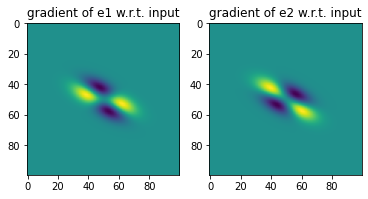

In [20]:
print(end)
print(z_star[0])
subplot(121)
imshow(grad2[0,...])
title('gradient of e1 w.r.t. input')

subplot(122)
imshow(grad2[1,...])
title('gradient of e2 w.r.t. input')

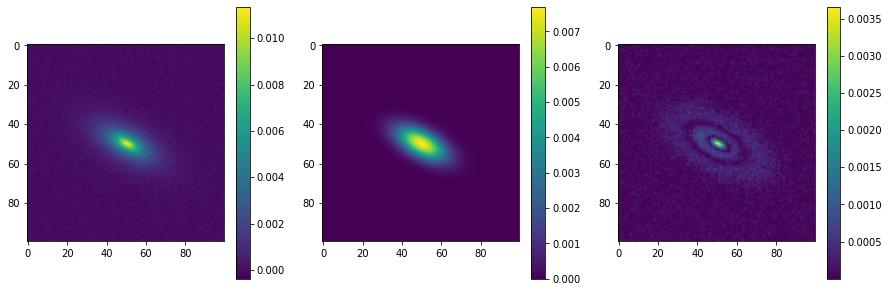

In [21]:
mod = model(z_star)
figure(figsize=(15,5))
subplot(131)
imshow(im)
colorbar()
subplot(132)
imshow(mod)
colorbar()
subplot(133)
imshow(abs((mod-im)))
colorbar()

In [22]:
g1 = tf.reshape(tf.convert_to_tensor(end[0], dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(end[1], dtype=tf.float32), [-1])
g1
mod = tf.reshape(tf.convert_to_tensor(mod, dtype=tf.float32), [1,N,N,1])
#mod.shape
#N

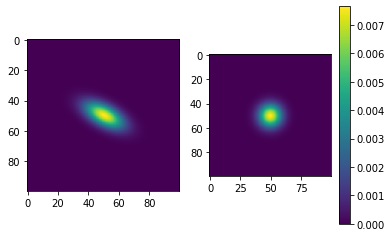

In [23]:
subplot(121)
imshow(mod[0,...,0])
subplot(122)
unsheared = gf.shear(mod, -g1, -g2)
imshow(unsheared[0,...,0])
colorbar()

In [24]:
#hist = unsheared[0,...,0] * coords
#tf.reduce_max(unsheared) / 4 / tf.math.log(2*tf.math.sqrt(2.))
tf.math.sqrt(1. / np.pi / tf.reduce_max(unsheared)/2) * pixel_scale

<tf.Tensor: shape=(), dtype=float32, numpy=0.9117656>

## With higher input noise

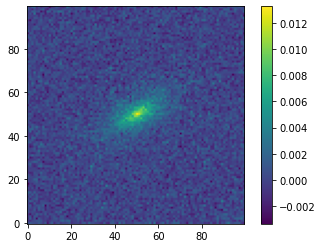

In [25]:
gal_flux = 2.5    # counts
gal_r0 = 1.1      # arcsec
pixel_scale = 0.2  # arcsec / pixel
N = 100            # image width/height

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=N,ny=N, scale=pixel_scale),
                               x_interpolant='linear')

imgal = gal.drawImage(nx=N, ny=N, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)

imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

g1 = 0.2
g2 = 0.3
g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])

imgal = gf.shear(imgal, g1, g2)

im2 = imgal[0,...,0] + 0.001*tf.random.normal([N,N])
imshow(im2, origin='lower')
colorbar()

In [28]:
with tf.GradientTape() as g:
  g.watch(im)
  end = get_ellipticity_implicit(im)
  #end = (lambda x: tf.reduce_sum(fixed_point_layer_implicit(x)))(im)
  #end = tf.reduce_sum(fixed_point_layer_implicit(im))

grad2 = g.jacobian(end, im)
grad2.shape

TensorShape([2, 100, 100])

In [29]:
# ellipticiries
end

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.19911277, 0.2982918 ], dtype=float32)>

Text(0.5, 1.0, 'gradient of e2 w.r.t. input')

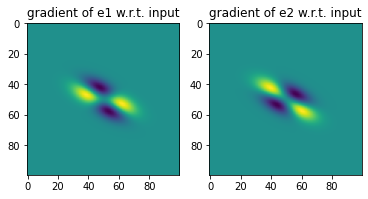

In [30]:
# gradients
subplot(121)
imshow(grad2[0,...])
title('gradient of e1 w.r.t. input')

subplot(122)
imshow(grad2[1,...])
title('gradient of e2 w.r.t. input')